In [1]:
import numpy as np
import scipy.stats as st
import scipy.integrate as si
import matplotlib.pyplot as plt
from generate_triple_data import par, simulate
import networkx as nx
from nxpd import draw
from scipy.optimize import leastsq
import statsmodels.api as sm
from collections import defaultdict
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams.update({
    k: 'xx-large' for k in plt.rcParams 
    if (
        k.endswith('labelsize') or
        k.endswith('fontsize')
    )
})

## Simulate the triple setup
Neurons A,B,C have statistical dependency as given by the graph below

Stimulation S is randomly assigned, but identical for A and B

We want to determine the causal connectivity between A and C, and B and C.

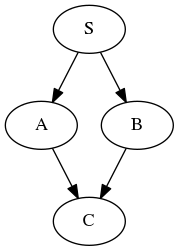

In [3]:
G = nx.DiGraph()
G.add_nodes_from(['A', 'B', 'C', 'S'])
G.add_edges_from([('A','C'), ('B', 'C'), ('S', 'A'), ('S', 'B')])
draw(G, show='ipynb')

In [104]:
def histogram(val, bins):
    '''
    Assuming:
        val, bins are sorted
        bins increase monotonically and uniformly
        all(bins[0] <= v <= bins[-1] for v in val)
    '''
    result = np.zeros(len(bins) - 1).astype(int)
    search = np.searchsorted(bins, val, side='right')
    cnt = np.bincount(search)[1:]
    result[:len(cnt)] = cnt[:len(result)]
    if len(cnt) > len(result):
        print('Assert', np.allclose(np.histogram(val, bins)[0], result))
    return result
    

def create_design_matrix(times, bins, n):
    result = [histogram(times, bins=bins)]
    for i in range(1, n):
        result.append(
            np.concatenate([
                np.zeros(i),
                result[0][:-i]
            ])
        )
    return np.array(result)


def OLS(X, y):
    dot, inv = np.dot, np.linalg.inv
    return dot(dot(inv(dot(X.T, X)), X.T), y)


def IV(pre, post, stim_times, stop_time, sigma=1, refractory=3, latency=4):

    bins = np.arange(0, stop_time + sigma, sigma)
    
    pre_binary_design = create_design_matrix(
        pre, bins, int(refractory / sigma) + 1)
    
    X = pre_binary_design[0]
    Z = pre_binary_design[1:]
    
    S = create_design_matrix(
        stim_times, bins, int(refractory / sigma) - 1).sum(axis=0).astype(bool)
    
    Y = histogram(post - latency + refractory / 4, bins=bins)
    
    Z = Z.T
    Z = np.hstack((np.ones((Z.shape[0], 1)), Z))
    
    W = OLS(Z, X)
    X_fittedvalues = np.dot(W, Z.T)
    
    Y = Y[S]
    X_fittedvalues = X_fittedvalues[S]
    
    XX = np.array([np.ones(X_fittedvalues.shape[0]), X_fittedvalues])

    _, beta_IV = OLS(XX.T, Y)
    
    return beta_IV


def xcorr(t1, t2, binsize=1e-3, limit=[-1, 1], density=False):
    '''
    Cross correlation histogram (CCH) of t1 vs t2
    '''
    if isinstance(limit, (int, float)):
        limit = [-limit, limit]
    bins = np.arange(limit[0], limit[1] + binsize, binsize)
    ii2 = np.searchsorted(t2, t1 + limit[0])
    jj2 = np.searchsorted(t2, t1 + limit[1])
    big = np.concatenate([t2[i:j] - t for t, i, j in zip(t1, ii2, jj2)])
    count, bins = np.histogram(big, bins=bins, density=density)
    
    return bins[1:], count


def fit_latency(pre, post, binsize=.1, limit=[-10, 20], init=[0.5, 0.5], plot=False):
    '''
    Fit a gaussian PDF to density of CCH
    '''
    b, c = xcorr(pre, post, binsize=binsize, limit=limit, density=True)
    normpdf  = lambda p, x: st.lognorm.pdf(x, p[0], p[1])
    error  = lambda p, x, y: (y - normpdf(p, x))
    (delta_t, sigma), _ = leastsq(error, init, args=(b, c))
    if plot:
        plt.bar(b, c, width=-binsize, align='edge')
        y = normpdf((delta_t, sigma), b)
        plt.plot(b, y, 'r--', linewidth=2)
        plt.title('$\Delta t$ {:.2f} $\sigma$ {:.2f}'.format(delta_t, sigma))
#         plt.axvspan(delta_t - sigma, delta_t + sigma, alpha=.5, color='cyan')
    return delta_t, sigma

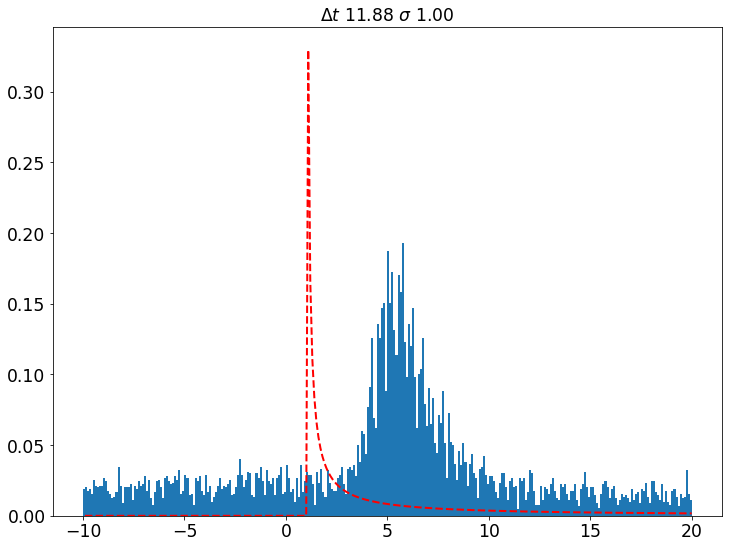

In [103]:
latency, winsize = fit_latency(stim_times, C_spikes, plot=True)

In [105]:
results = defaultdict(list)
amps = np.arange(0, 3.1, .1)
latency = 6
for a in amps:
    data = simulate(par, stim_N=10000, J_AC=a, J_BC=0.0, stim_amp_A=6., stim_amp_B=6.)
    stop_time = data['status']['time']
    A_spikes, B_spikes, C_spikes = [s['times'] for s in data['spiketrains']]
    
    stim_times = data['epoch']['times']
    
    beta_AC = IV(A_spikes, C_spikes, stim_times, stop_time, latency=latency)
    beta_BC = IV(B_spikes, C_spikes, stim_times, stop_time, latency=latency)
    
    time_shift = 15
    
    beta_ACr = IV(A_spikes, C_spikes, stim_times - time_shift, stop_time, latency=latency)
    beta_BCr = IV(B_spikes, C_spikes, stim_times - time_shift, stop_time, latency=latency)
    
    beta_AC_corrected = beta_AC - beta_ACr
    beta_BC_corrected = beta_BC - beta_BCr
    
    results['beta_AC'].append(beta_AC)
    results['beta_BC'].append(beta_BC)    
    results['beta_ACr'].append(beta_ACr)    
    results['beta_BCr'].append(beta_BCr)    
    results['beta_ACc'].append(beta_AC_corrected)    
    results['beta_BCc'].append(beta_BC_corrected)
    results['rate_A'].append(len(A_spikes) / stop_time * 1000)
    results['rate_B'].append(len(B_spikes) / stop_time * 1000)
    results['rate_C'].append(len(C_spikes) / stop_time * 1000)

simulating  426364.0
stimulating  10000
simulating  425147.0
stimulating  10000
connecting  J_AC 0.1
simulating  426312.0
stimulating  10000
connecting  J_AC 0.2
simulating  426331.0
stimulating  10000
connecting  J_AC 0.30000000000000004
simulating  426523.0
stimulating  10000
connecting  J_AC 0.4
simulating  426453.0
stimulating  10000
connecting  J_AC 0.5
simulating  426523.0
stimulating  10000
connecting  J_AC 0.6000000000000001
simulating  424588.0
stimulating  10000
connecting  J_AC 0.7000000000000001
simulating  423764.0
stimulating  10000
connecting  J_AC 0.8
simulating  424876.0
stimulating  10000
connecting  J_AC 0.9
simulating  426596.0
stimulating  10000
connecting  J_AC 1.0
simulating  424590.0
stimulating  10000
connecting  J_AC 1.1
simulating  426533.0
stimulating  10000
connecting  J_AC 1.2000000000000002
simulating  426247.0
stimulating  10000
connecting  J_AC 1.3
simulating  425055.0
stimulating  10000
connecting  J_AC 1.4000000000000001
simulating  425170.0
stimulati

In [106]:
results = {k: np.array(v) for k, v in results.items()}

Text(0.5,1,'BC')

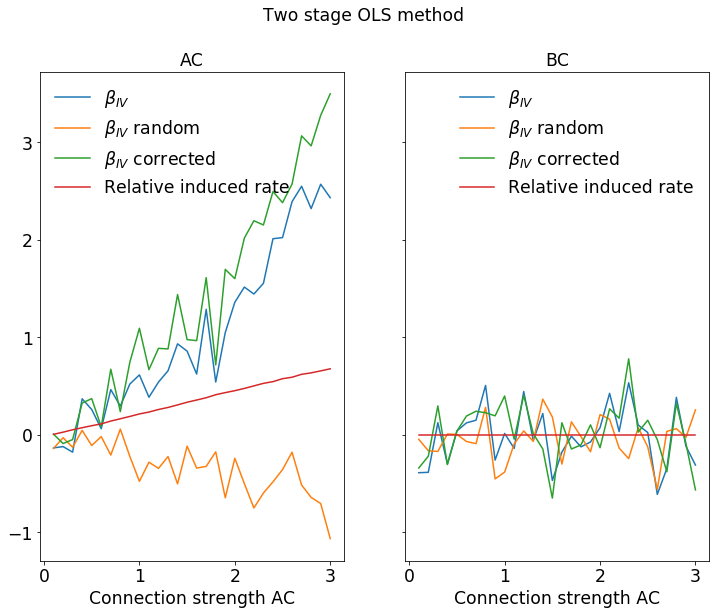

In [107]:
fig, (axa, axb) = plt.subplots(1,2, sharey=True)

plt.suptitle('Two stage OLS method', fontsize='xx-large')

axa.plot(amps[1:], results['beta_AC'][1:], label=r'$\beta_{IV}$')
axa.plot(amps[1:], results['beta_ACr'][1:], label=r'$\beta_{IV}$ random')
axa.plot(amps[1:], results['beta_ACc'][1:], label=r'$\beta_{IV}$ corrected')
axa.plot(amps[1:], results['rate_C'][1:] / results['rate_C'][0] - 1, label='Relative induced rate')
axa.legend(frameon=False, loc=0)
axa.set_xlabel('Connection strength AC')
axa.set_title('AC')

axb.plot(amps[1:], results['beta_BC'][1:], label=r'$\beta_{IV}$')
axb.plot(amps[1:], results['beta_BCr'][1:], label=r'$\beta_{IV}$ random')
axb.plot(amps[1:], results['beta_BCc'][1:], label=r'$\beta_{IV}$ corrected')
axb.plot(amps[1:], np.zeros_like(amps[1:]), label='Relative induced rate')
axb.legend(frameon=False, loc=0)
axb.set_xlabel('Connection strength AC')
axb.set_title('BC')